# Air Transportation Ocurrences
## Exploring Relationships Between Aviation Incidents and External Factors

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../scripts")

In [5]:
from data_loader import load_data_from_csv, load_data_from_temp, load_data_from_filtered
from common.export_csv import exportDataVersion
import pandas as pd
import numpy as np

In [6]:
#Load occurrences data
occurrences_df = load_data_from_csv('fullData_V2.csv')
#Data length
print(f"# of rows 'fullData_V2.csv': {len(occurrences_df)}")

# of rows 'fullData_V2.csv': 47781


In [7]:
#Load dollar exchange
dollar_df = load_data_from_filtered("dollar_exchange_filtered.csv")

In [8]:
#Load birth rate
births_df = load_data_from_filtered("birth_rate_filtered.csv")

In [9]:
#Load passenger traffic 
passenger_traffic = load_data_from_filtered("passenger_traffic_filtered.csv")

## Creating a file with number of occurrences, births and dolar exchange monthly

In [11]:
from exploring_relationships.create_merged_file import createFileWithMergedDatasets

In [12]:
#createFileWithMergedDatasets(occurrences_df, passenger_traffic, dollar_df, births_df)

In [13]:
df = load_data_from_csv('fullData_V3.csv')

In [14]:
from exploring_relationships.relationship_functions import (
getBirthRelation, 
getDollarRelation, 
getPassengerTrafficRelation
)

### Correlation with birth date 

occurrences    0
births         0
dtype: int64
Correlation between occurrences and births: 0.2498


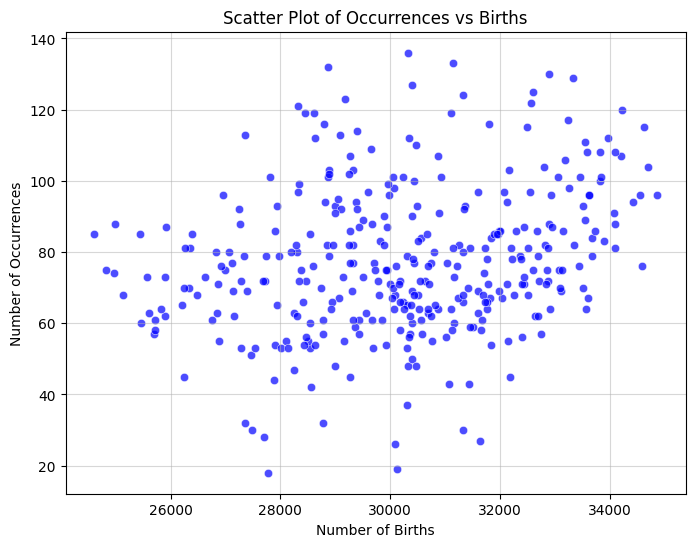

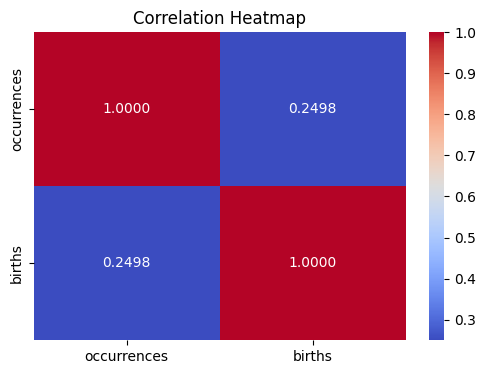

In [16]:
getBirthRelation(df)

### Correlation with Dollar Exchange

occurrences         0
dollar_exchange    80
dtype: int64
Correlation between occurrences and dollar_exchange: 0.1497


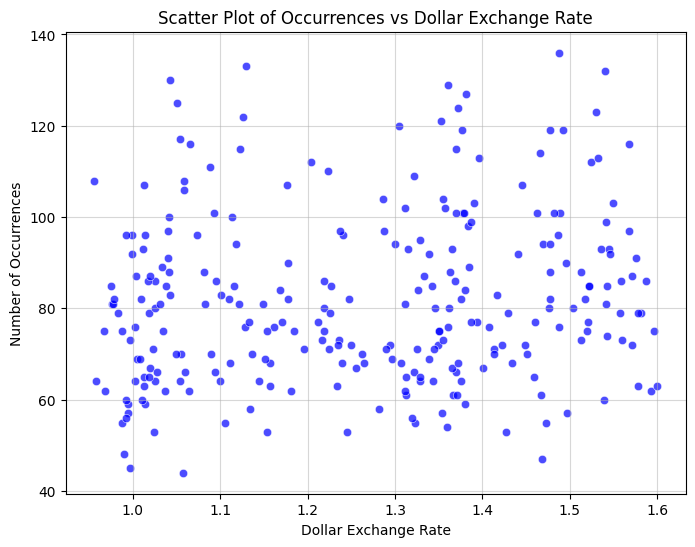

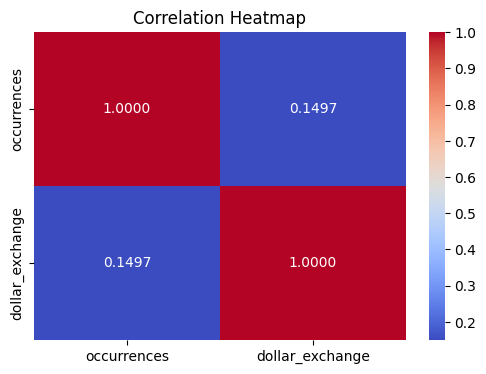

In [18]:
getDollarRelation(df)

### Correlation with Passenger Traffic 

occurrences            0
passenger_traffic    288
dtype: int64
Correlation between occurrences and passenger traffic: 0.7426


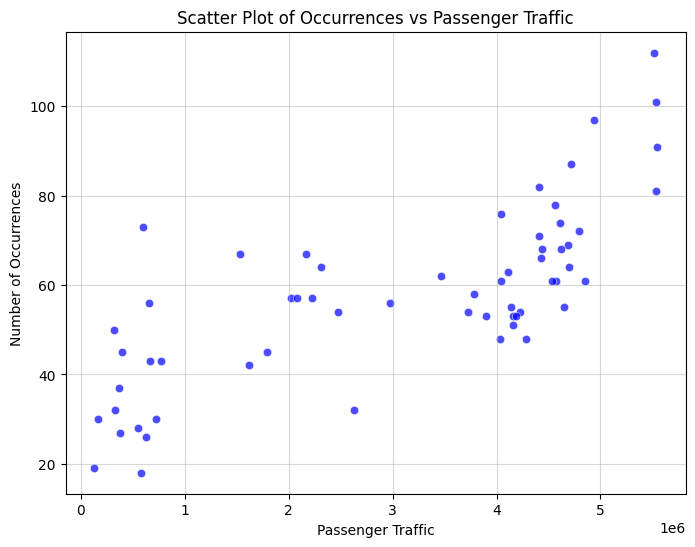

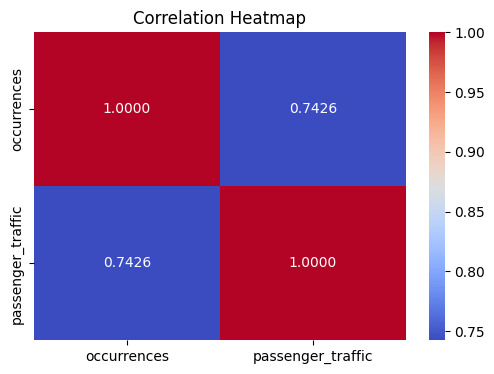

In [20]:
getPassengerTrafficRelation(df)

### LineChart 

In [22]:
from exploring_relationships.line_chart_occurrences_births_traffic import plotLineChart

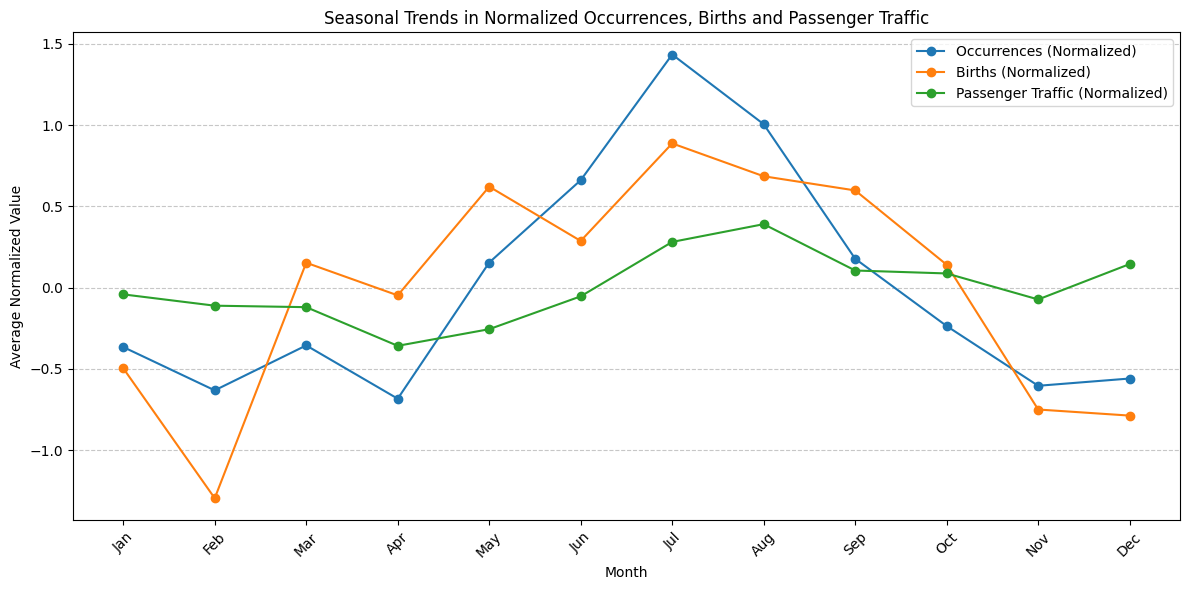

In [23]:
plotLineChart(df)

### Correlation Matrix

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

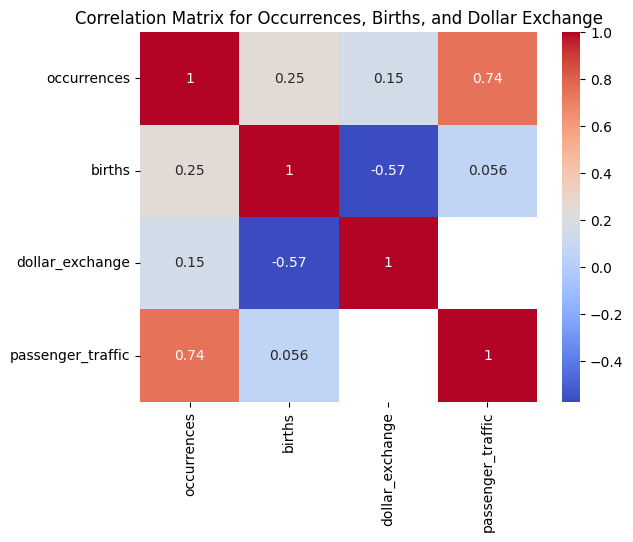

In [37]:
corr_matrix = df[['occurrences', 'births', 'dollar_exchange', 'passenger_traffic']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Occurrences, Births, and Dollar Exchange')
plt.show()

### line chart with occurrences and passenger traffic 

In [40]:
from exploring_relationships.line_chart_occurrences_passenger_traffic import plotLineChartOccurrencesAndPassengerTraffic

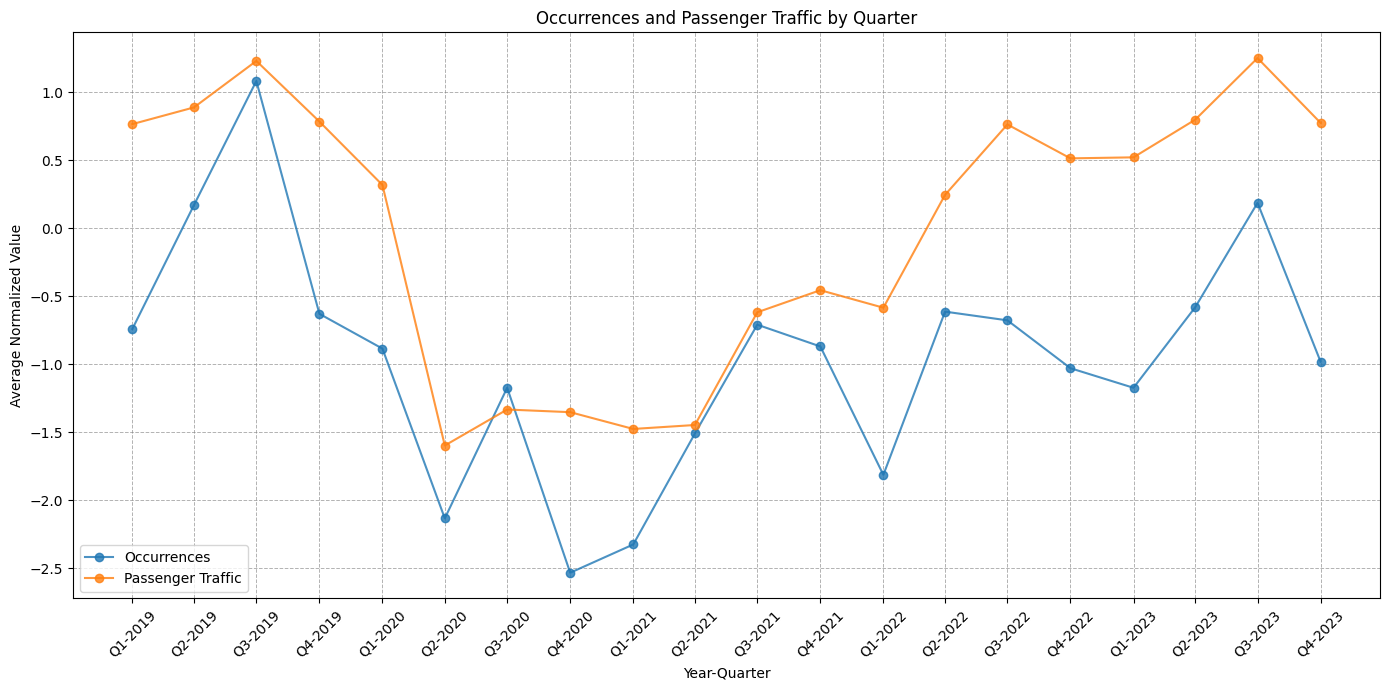

In [42]:
plotLineChartOccurrencesAndPassengerTraffic(df)